## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

# Value Iteration for the Double Integrator

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython import get_ipython

from pydrake.all import (
  DiagramBuilder, DynamicProgrammingOptions, FittedValueIteration, 
  LinearSystem, Simulator
)
from underactuated.double_integrator import DoubleIntegratorVisualizer


def DoubleIntegrator():
  return LinearSystem(A=np.mat('0 1; 0 0'),
                      B=np.mat('0; 1'),
                      C=np.eye(2),
                      D=np.zeros((2,1)))

plant = DoubleIntegrator()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()

qbins = np.linspace(-3., 3., 31)
qdotbins = np.linspace(-3., 3., 51)
state_grid = [set(qbins), set(qdotbins)]

input_limit = 1.
input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 20 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax1.plot_surface(Q, Qdot, J, rstride=1, cstride=1, cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

    if plt.get_backend() != u"template":
        fig.canvas.draw()
        plt.pause(1e-10)

    surf.remove()
    surf2.remove()

if plt_is_interactive:
    options.visualization_callback = draw

def solve():
    policy, cost_to_go = FittedValueIteration(simulator, cost_function, state_grid,
                                              input_grid, timestep, options)

    J = np.reshape(cost_to_go, Q.shape)
    surf = ax1.plot_surface(Q, Qdot, J, rstride=1, cstride=1, cmap=cm.jet)
    Pi = np.reshape(policy.get_output_values(), Q.shape)
    surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)
    return policy
    
def simulate():
    # Animate the resulting policy.
    builder = DiagramBuilder()
    plant = builder.AddSystem(DoubleIntegrator())

    vi_policy = builder.AddSystem(policy)
    builder.Connect(plant.get_output_port(0), vi_policy.get_input_port(0))
    builder.Connect(vi_policy.get_output_port(0), plant.get_input_port(0))

    visualizer = builder.AddSystem(DoubleIntegratorVisualizer())
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)

    simulator.get_mutable_context().SetContinuousState([-10.0, 0.0])

    simulator.AdvanceTo(10. if get_ipython() is not None else 0.1)


In [ ]:
def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < .05:
        return 0.
    return 1.

cost_function = min_time_cost
options.convergence_tol = 0.001

fig = plt.figure(figsize=(9, 4))
ax1, ax2 = fig.subplots(1, 2, subplot_kw=dict(projection='3d'))
ax1.set_xlabel("q")
ax1.set_ylabel("qdot")
ax1.set_title("Cost-to-Go")
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")
ax2.set_title("Policy")

policy = solve()

In [ ]:
simulate()

<IPython.core.display.Javascript object>


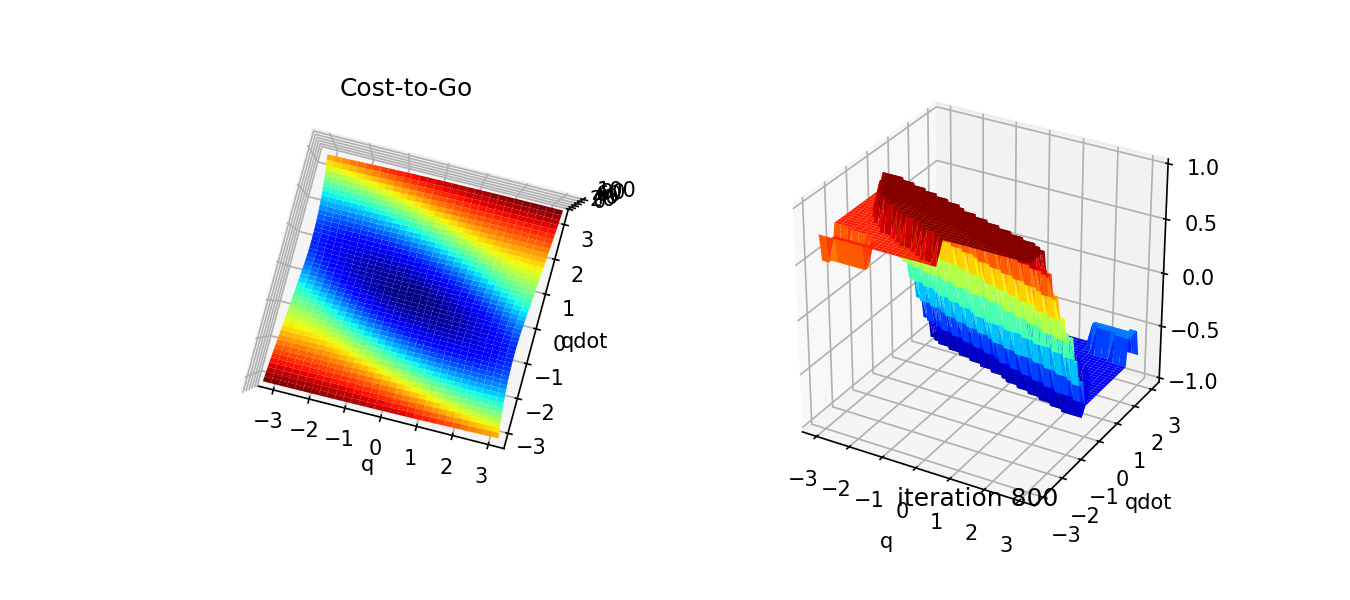

In [3]:
def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return x.dot(x) + 20 * u.dot(u)

cost_function = quadratic_regulator_cost
options.convergence_tol = 0.1

fig = plt.figure(figsize=(9, 4))
ax1, ax2 = fig.subplots(1, 2, subplot_kw=dict(projection='3d'))
ax1.set_xlabel("q")
ax1.set_ylabel("qdot")
ax1.set_title("Cost-to-Go")
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")
ax2.set_title("Policy")

policy = solve()

In [ ]:
simulate()

# Linear Quadratic Regulator

The cost function we used above actually has a closed-form solution, given by the Linear Quadratic Regulator.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pydrake.systems.controllers import LinearQuadraticRegulator

# Define the double integrator's state space matrices.
A = np.mat('0 1; 0 0')
B = np.mat('0; 1')
Q = np.eye(2)
R = np.eye(1)

(K, S) = LinearQuadraticRegulator(A, B, Q, R)
print("K = " + str(K))
print("S = " + str(S))


K = [[1.         1.73205081]]
S = [[1.73205081 1.        ]
 [1.         1.73205081]]


In [ ]:

fig = plt.figure(figsize=(9, 4))
ax1, ax2 = fig.subplots(1, 2, subplot_kw=dict(projection='3d'))
ax1.set_xlabel("q")
ax1.set_ylabel("qdot")
ax1.set_title("Cost-to-Go")
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")
ax2.set_title("Policy")

qbins = np.linspace(-3., 3., 31)
qdotbins = np.linspace(-3., 3., 51)
[Q, Qdot] = np.meshgrid(qbins, qdotbins)
print(Q)